In [829]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)
pd.set_option("display.max_colwidth", 200)

In [830]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

For reference: https://nbviewer.jupyter.org/github/IncioMan/socialdata/blob/master/FinalProject/TrafficDataProject.ipynb

### Import

In [831]:
methods= ["direct_and_pr", "iterative_pr_head_ref_cherry_picked"]

In [832]:
direct_and_pr = pd.read_csv(f"{csv_folder}/final_datasets/{methods[0]}_with_sw_metrics.csv", index_col=0)

In [833]:
iterative_pr_head_ref_cherry_picked = pd.read_csv(f"{csv_folder}/final_datasets/{methods[1]}_with_sw_metrics.csv", index_col=0)

In [834]:
methods_df = {"direct_and_pr":direct_and_pr,
             "iterative_pr_head_ref_cherry_picked": iterative_pr_head_ref_cherry_picked}

### Features

| Variable name                            | Variable description                                                                                               | Variable type | How many      |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------|---------------|
| ratio_{state}_build                      | Ratio number of builds in the state over all builds for the release                                                | Continuous    | 4             |
| ratio_pr_build                           | Ratio number of pull request builds in the state over all builds for the release                                   | Continuous    | 1             |
| {aggr}_{state}_build_duration            | Aggregation for the duration of the builds in that state for the release                                           | Continuous    | 4 \* 3 = 12   |
| {aggr}\_n\_builds_per_pull_request       | Aggregation of the number of builds per pull request for the release                                               | Continuous    | 4             |
| {aggr}_failed_tests                      | Aggregation of the number failed tests per build for the release                                                   | Continuous    | 4             |
| {aggr}_errors_over_tests_total           | Aggregation of the number of error words over the tests run per build for the release                              | Continuous    | 4             |
| {aggr}_failures_over_tests_total         | Aggregation of the number of failures words over the tests run per build for the release                           | Continuous    | 4             |
| {aggr}_skipped_over_tests_total          | Aggregation of the number of skipped words over the tests run per build for the release                            | Continuous    | 4             |
| {aggr}\_n\_exceptions                    | Aggregation of the number of thrown exceptions per build for the release                                           | Continuous    | 4             |
| {aggr}\_n\_warnings                      | Aggregation of the number of warning words per build for the release                                               | Continuous    | 4             |
| {aggr}\_n\_error_classes                 | Aggregation of the number of error classes thrown per build for the release                                        | Continuous    | 4             |
| {state}\_gp{x}\_bs{y}\_n\_bursts_{aggr}  | Aggregation over number of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y    | Continuous    | 3 \*9 \*4=108 |
| {state}\_gp{x}\_bs{y}\_burst_size_{aggr} | Aggregation over the sizes of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y | Continuous    | 3 \*9 \*4=108 |
|                                          |                                                                                                                    |               | Total = 265   |

**Size**

In [835]:
for method in methods:
    print(methods_df[method].shape)

(52, 287)
(52, 287)


**Number burst metrics**

In [836]:
for method in methods:
    print(len([x for x in methods_df[method].columns if "burst" in x]))

216
216


**Number non burst metrics**

In [837]:
for method in methods:
    print(len([x for x in methods_df[method].columns if not "burst" in x]))

71
71


**Extracting the dependent variables** 

In [838]:
dep_var_cols = ["post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]

In [839]:
methods_dep_var = {}
for method in methods:
    methods_dep_var[method] = methods_df[method]\
    [dep_var_cols]

**Extracting the independent variables**

In [840]:
extra_info_cols = ['version_name','from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag']

In [841]:
pre_release_bugs_columns = ["pre_release_bugs"]

In [842]:
methods_indep_var = {}
for method in methods:
    methods_indep_var[method] = methods_df[method].drop(columns=extra_info_cols + pre_release_bugs_columns + dep_var_cols)
    print(method, methods_indep_var[method].shape)

direct_and_pr (52, 265)
iterative_pr_head_ref_cherry_picked (52, 265)


### Missing values

In [843]:
methods_indep_var[methods[0]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [844]:
methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [845]:
df = methods_indep_var[methods[0]]
df[df.min_failed_build_duration.isna()]

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,min_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,min_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,min_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,min_n_error_classes,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,...,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs2_burst_size_min,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp1_bs3_burst_size_min,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min
34,1.000000,0.0,0.0,0.000000,0.0,1343.090909,1339.0,1529.0,1146.0,NaN,NaN,NaN,NaN,1343.090909,1339.0,1529.0,1146.0,11.000000,11.0,11,11,1.501101,1.501109,3.0,0.002188,0.0,0.0,0.0,0.0,2.001101,2.001109,4.0,0.002188,0.000367,0.000365,0.00074,0.000000,0.000000,0.0,0,0,19.000000,19.0,22.0,16.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,

If we look at the ratio of builds in the state, we see that both datasets have missing values for duration due to no builds in that state being associated with that release.
We replace the values with 0.

In [846]:
for method in methods:
    methods_indep_var[method].fillna(0, inplace=True)

In [847]:
len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0])\
+ len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[0]].isna().sum()>0])

0

### Drop columns with no information

In [848]:
method_uninformative_columns = {}
for method in methods:
    df = methods_indep_var[method]
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    method_uninformative_columns[method] = cols_to_drop
    methods_indep_var[method] = df.drop(cols_to_drop, axis=1)
    print(method, methods_indep_var[method].shape)

direct_and_pr (52, 235)
iterative_pr_head_ref_cherry_picked (52, 214)


In [849]:
method_uninformative_columns[methods[0]].nunique()

30

In [850]:
set(method_uninformative_columns[methods[0]]).difference(set(method_uninformative_columns[methods[1]]))

set()

In [851]:
set(method_uninformative_columns[methods[1]]).difference(set(method_uninformative_columns[methods[0]]))

{'canceled_gp1_bs3_n_bursts_min',
 'canceled_gp2_bs1_n_bursts_min',
 'canceled_gp2_bs2_n_bursts_min',
 'canceled_gp2_bs3_n_bursts_min',
 'canceled_gp3_bs1_n_bursts_min',
 'canceled_gp3_bs2_n_bursts_min',
 'canceled_gp3_bs3_n_bursts_min',
 'failed_gp1_bs3_n_bursts_min',
 'failed_gp2_bs1_n_bursts_min',
 'failed_gp2_bs2_n_bursts_min',
 'failed_gp2_bs3_n_bursts_min',
 'failed_gp3_bs1_n_bursts_min',
 'failed_gp3_bs2_n_bursts_min',
 'failed_gp3_bs3_n_bursts_min',
 'not_passed_gp1_bs3_n_bursts_min',
 'not_passed_gp2_bs1_n_bursts_min',
 'not_passed_gp2_bs2_n_bursts_min',
 'not_passed_gp2_bs3_n_bursts_min',
 'not_passed_gp3_bs1_n_bursts_min',
 'not_passed_gp3_bs2_n_bursts_min',
 'not_passed_gp3_bs3_n_bursts_min'}

### Statistical summary

**Method 1**

Not burst metrics

In [852]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_all_build_duration,median_all_build_duration,max_all_build_duration,min_all_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.769804,0.049930,0.107409,0.072858,0.288482,2390.239832,2487.471154,13033.711538,564.192308,1651.513973,1675.480769,2745.576923,756.846154,2670.109314,2586.730769,4605.711538,1747.673077,6.983362,4.144231,104.173077,2.634615,6.881471,4.485119,654.942986,0.001201,0.380881,0.201923,63.346154,2.249739,0.618805,532.558161,0.007581,5.449230,2.978306,97.204812,0.000036,19.759538,2.269231,210.980769,116.501444,21.634615,815.923077,2.403846,0.920856,0.115385,30.269231
std,0.163330,0.055365,0.081205,0.147760,0.276243,1498.835762,1616.947134,57077.485698,892.683178,1936.459052,2078.319273,2969.736731,1311.794077,1805.062684,1738.237942,3666.306719,1436.675912,9.520588,9.629070,210.828126,8.324377,14.447417,13.249594,2708.510067,0.001537,1.498247,1.456088,240.937538,5.152182,0.843577,2588.488968,0.025895,7.201269,6.479358,215.832812,0.000125,21.123590,7.003124,522.451067,107.719442,20.219171,1024.539549,5.584501,1.231825,0.582552,132.535177
min,0.000000,0.000000,0.000000,0.000000,0.000000,832.235294,940.000000,1187.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.087503,0.000000,0.188000,0.000000,0.000000,0.000000,0.000000,0.069257,0.000456,0.161137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.500000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,0.704412,0.000000,0.050331,0.000000,0.000000,1264.544165,1307.750000,2332.750000,0.000000,482.916667,399.625000,735.500000,51.750000,1385.782598,1359.750000,2318.250000,831.750000,3.125000,1.000000,9.000000,1.000000,0.455791,0.150991,3.750000,0.000000,0.000000,0.000000,0.000000,0.620497,0.042795,5.000000,0.000000,0.090024,0.000492,1.250000,0.000000,1.000000,0.000000,2.750000,21.307143,6.375000,57.500000,0.000000,0.000000,0.000000,0.000000
50%,0.773504,0.033269,0.101282,0.034585,0.267573,1649.598110,1784.750000,3220.500000,48.000000,927.500000,810.500000,1468.500000,258.500000,2071.239262,1914.250000,2998.000000,1211.500000,4.344332,1.500000,20.500000,1.000000,1.378893,0.714752,18.500000,0.000000,0.026261,0.000000,1.500000,1.222579,0.181918,9.000000,0.000000,1.804817,0.001272,31.500000,0.000000,9.533924,0.000000,70.500000,70.754580,13.250000,734.500000,0.000000,0.117865,0.000000,6.000000
75%,0.859524,0.098817,0.154858,0.083899,0.538858,2908.527778,2956.500000,7555.000000,951.750000,1467.116197,1429.500000,

Our features are all continuous:
* Because of their nature we know they should not present negative values and indeed they do not
* Ratio features should range between 0 and 1: they correctly do
* Min_all_build_duration presents negative values: this is due to erros in the build dataset (fixed)

Burst metrics

In [853]:
methods_indep_var[methods[0]].shape

(52, 235)

In [854]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if "burst" in x]].describe()

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_median,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_n_bursts_min,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_n_bursts_min,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_median,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_n_bursts_min,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_median,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_n_bursts_min,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_n_bursts_min,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_median,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_n_bursts_min,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_median,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_n_bursts_min,...,failed_gp1_bs1_n_bursts_min,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_median,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_n_bursts_min,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,5

Burst metrics should all be positive and they indeed are

### Perfectly correlated features

In [883]:
methods_fully_correlated_features = {}
for method in methods:
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_fully_correlated_features[method] = sol[sol > 0.999]

In [884]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    for pair in methods_fully_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    print(method, len(cols_to_remove))

direct_and_pr 142
iterative_pr_head_ref_cherry_picked 127


**How many columns to remove due to perfect correlation are burst metric?**

In [885]:
for method in methods:
    print(method, len([col for col in methods_corr_cols_to_remove[method] if "burst" in col])\
          /len(methods_corr_cols_to_remove[method]))

direct_and_pr 1.0
iterative_pr_head_ref_cherry_picked 0.9921259842519685


There are a couple not burst features

In [886]:
[col for col in methods_corr_cols_to_remove[methods[0]] if  not "burst" in col]

[]

In [887]:
[col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]

['min_n_builds_per_pull_request']

In [890]:
for col in [col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]:
    x = methods_fully_correlated_features[methods[1]]
    print(col,":\n", x[col])

min_n_builds_per_pull_request :
 not_passed_gp1_bs1_n_bursts_min    1.0
failed_gp1_bs1_n_bursts_min        1.0
failed_gp1_bs2_n_bursts_min        1.0
canceled_gp1_bs1_n_bursts_min      1.0
not_passed_gp1_bs2_n_bursts_min    1.0
canceled_gp1_bs2_n_bursts_min      1.0
dtype: float64


Remove the perfectly correlated columns

In [891]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(52, 93)
(52, 87)


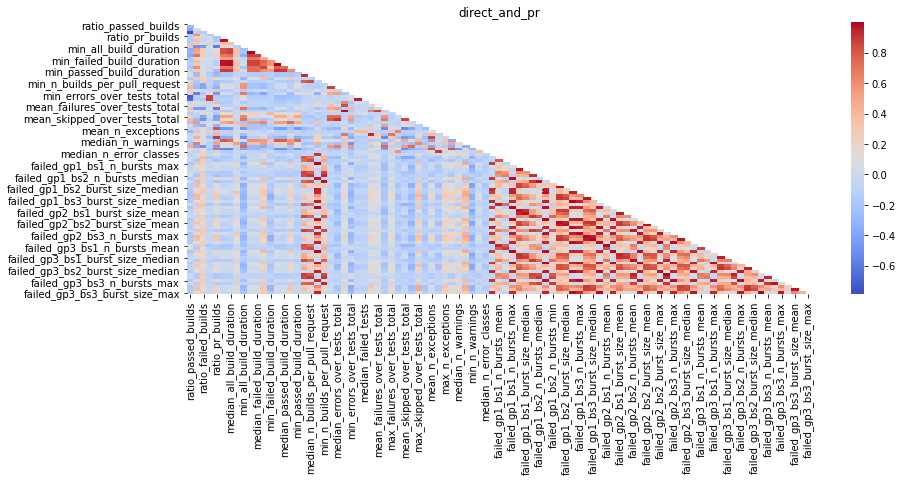

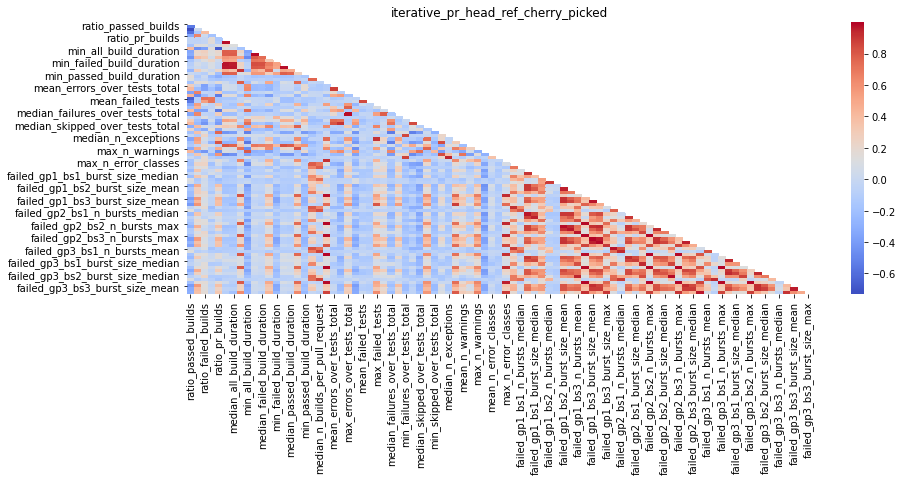

In [892]:
for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

**Do datasets have same columns?**

In [894]:
set(methods_indep_var[methods[0]]).difference(set(methods_indep_var[methods[1]]))

{'failed_gp1_bs1_n_bursts_max',
 'failed_gp1_bs2_burst_size_max',
 'failed_gp1_bs2_n_bursts_max',
 'failed_gp2_bs1_n_bursts_max',
 'failed_gp2_bs2_burst_size_max',
 'failed_gp3_bs2_burst_size_max',
 'failed_gp3_bs3_n_bursts_min',
 'min_n_builds_per_pull_request'}

### Correlated features

<Figure size 1008x360 with 0 Axes>

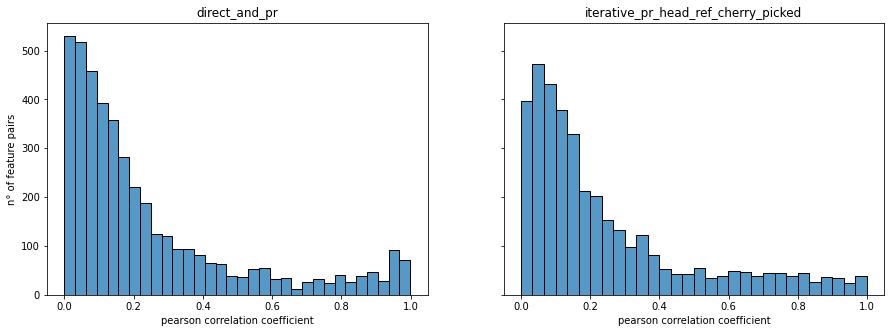

In [895]:
plt.figure()
methods_correlated_features = {}
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_correlated_features[method] = sol[sol > 0.8]
    ax = sns.histplot(sol, ax=axes[i])
    ax.set_title(method)
    ax.set(xlabel="pearson correlation coefficient",ylabel="n° of feature pairs")
plt.savefig(f"{figure_folder}/dataset_preprocessing/correlated_feature_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [898]:
methods_correlated_features[methods[1]].head(10)

failed_gp2_bs2_n_bursts_max     failed_gp3_bs2_n_bursts_max       0.999
max_n_builds_per_pull_request   failed_gp3_bs1_n_bursts_max       0.999
failed_gp2_bs3_n_bursts_max     failed_gp3_bs3_n_bursts_max       0.999
failed_gp1_bs3_n_bursts_max     failed_gp2_bs3_n_bursts_max       0.998
failed_gp3_bs1_n_bursts_max     failed_gp3_bs2_n_bursts_max       0.997
failed_gp2_bs2_n_bursts_max     failed_gp3_bs1_n_bursts_max       0.997
failed_gp1_bs3_n_bursts_max     failed_gp3_bs3_n_bursts_max       0.996
max_n_builds_per_pull_request   failed_gp3_bs2_n_bursts_max       0.996
                                failed_gp2_bs2_n_bursts_max       0.995
failed_gp1_bs3_burst_size_mean  failed_gp2_bs3_burst_size_mean    0.994
dtype: float64

In [897]:
methods_correlated_features[methods[0]].head(10)

failed_gp1_bs1_n_bursts_max    failed_gp3_bs1_n_bursts_max      0.999
failed_gp2_bs1_n_bursts_max    failed_gp3_bs1_n_bursts_max      0.999
failed_gp1_bs1_n_bursts_max    failed_gp2_bs1_n_bursts_max      0.998
failed_gp2_bs2_burst_size_max  failed_gp2_bs3_burst_size_max    0.998
failed_gp3_bs2_burst_size_max  failed_gp3_bs3_burst_size_max    0.998
failed_gp1_bs2_burst_size_max  failed_gp1_bs3_burst_size_max    0.998
failed_gp1_bs2_n_bursts_max    failed_gp2_bs2_n_bursts_max      0.997
failed_gp2_bs2_n_bursts_max    failed_gp3_bs2_n_bursts_max      0.996
failed_gp2_bs3_n_bursts_mean   failed_gp3_bs3_n_bursts_mean     0.995
failed_gp1_bs2_n_bursts_max    failed_gp3_bs2_n_bursts_max      0.995
dtype: float64

**Remove highly correlated features?**

methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    print(method, len(methods_correlated_features[method]))
    for pair in methods_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    #print(method, len(cols_to_remove))

for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

### Correlation with dependent variable
https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/

We proceed with analysing the correlation of our attributed with the three software quality metricsm
We calculate both types of correlation:
* Pearons (linear)
* Spearman (monotonic, is pearson applied to ranks)

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.

In [539]:
methods_pearson_corr_post_release_bugs = {}
methods_spearman_corr_post_release_bugs = {}
for method in methods:
    data = []
    corr_col = methods_dep_var[method].post_release_bugs
    methods_pearson_corr_post_release_bugs[method] = methods_indep_var[method]\
                                            .corrwith(corr_col)
    methods_spearman_corr_post_release_bugs[method] = methods_indep_var[method]\
                                            .corrwith(corr_col, method="spearman")

**Method 0 correlation analysis**

In [540]:
df = methods_pearson_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(10)

failed_gp3_bs3_burst_size_max       0.470321
failed_gp3_bs3_burst_size_median    0.404898
min_errors_over_tests_total        -0.305066
max_skipped_over_tests_total        0.277469
median_failures_over_tests_total   -0.264759
ratio_canceled_builds               0.262381
ratio_passed_builds                -0.259655
median_skipped_over_tests_total    -0.249059
min_skipped_over_tests_total       -0.241646
max_n_warnings                      0.209639
dtype: float64

<AxesSubplot:>

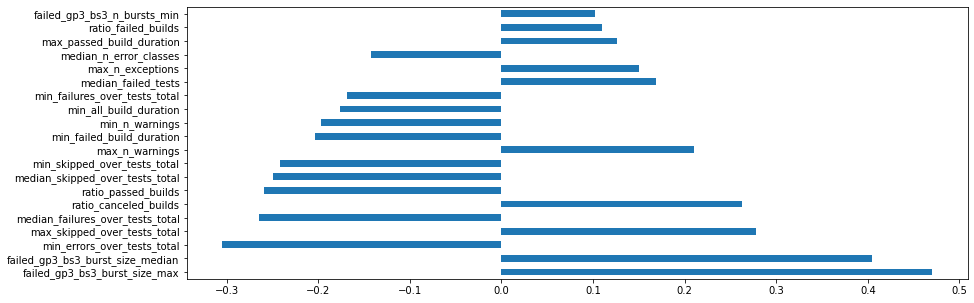

In [541]:
df = methods_pearson_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(20).plot(kind="barh")
#[[col for col in df.index if not "burst" in col]]

**Spearman correlation method0**

In [542]:
spearman_corr = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
spearman_corr = df.reindex(df.abs().sort_values(ascending=False).index)
spearman_corr.head(10)

failed_gp3_bs3_burst_size_max       0.470321
failed_gp3_bs3_burst_size_median    0.404898
min_errors_over_tests_total        -0.305066
max_skipped_over_tests_total        0.277469
median_failures_over_tests_total   -0.264759
ratio_canceled_builds               0.262381
ratio_passed_builds                -0.259655
median_skipped_over_tests_total    -0.249059
min_skipped_over_tests_total       -0.241646
max_n_warnings                      0.209639
dtype: float64

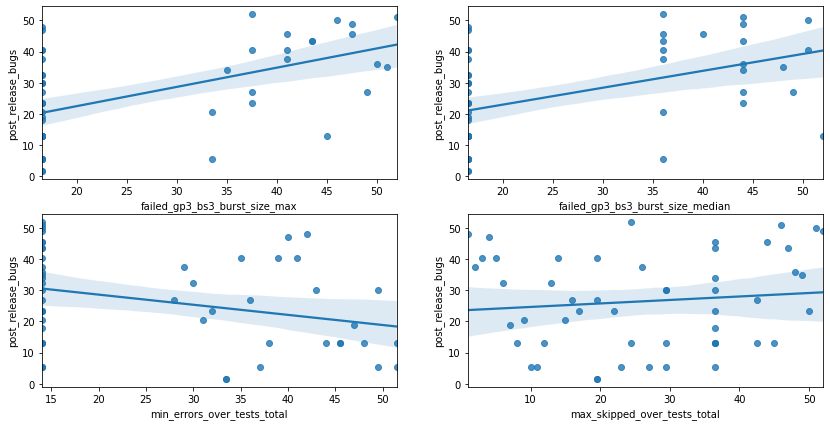

In [545]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14.0, 7.0))
axes = axes.flatten()
for i in range(4):
    feature = spearman_corr.index[i]
    sns.regplot(x=methods_indep_var[methods[0]][feature].rank(),
                   y=methods_dep_var[methods[0]].post_release_bugs.rank(), ax=axes[i])

Text(0.5, 1.0, 'Top 20 spearman rank correlations with post release bugs (no burst metrics)')

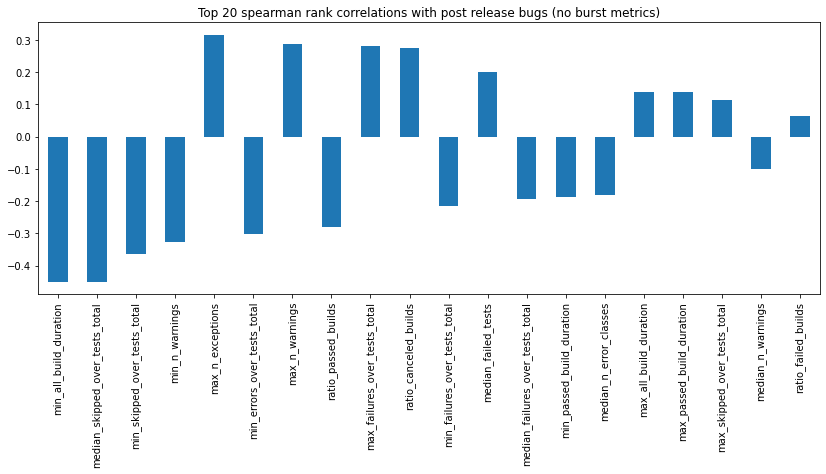

In [544]:
df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='failed_gp3_bs3_burst_size_max', ylabel='post_release_bugs'>

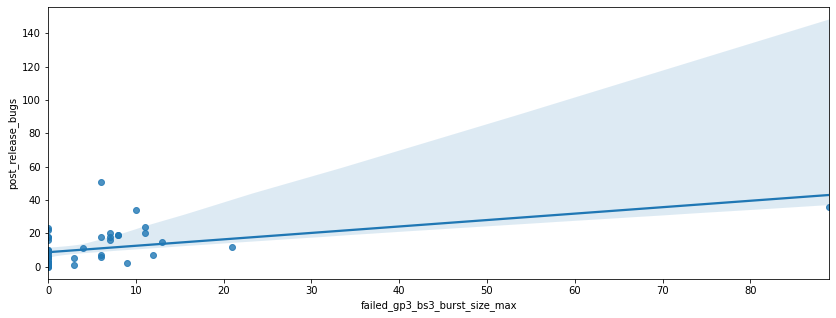

In [432]:
df_ind = methods_indep_var[methods[0]]
df_dep = methods_dep_var[methods[0]]
sns.regplot(df_ind.failed_gp3_bs3_burst_size_max, df_dep.post_release_bugs)

In [244]:
sol

not_passed_gp2_bs1_n_bursts_max     canceled_gp2_bs1_n_bursts_max        1.0
canceled_gp3_bs3_burst_size_median  failed_gp3_bs3_burst_size_median     1.0
not_passed_gp2_bs3_n_bursts_median  failed_gp3_bs2_n_bursts_median       1.0
not_passed_gp3_bs3_burst_size_mean  canceled_gp3_bs3_burst_size_mean     1.0
not_passed_gp2_bs3_n_bursts_median  failed_gp2_bs3_n_bursts_median       1.0
                                                                        ... 
mean_failed_tests                   not_passed_gp3_bs1_burst_size_max    0.0
                                    failed_gp3_bs1_burst_size_max        0.0
median_failed_build_duration        canceled_gp3_bs2_n_bursts_mean       0.0
                                    not_passed_gp3_bs2_n_bursts_mean     0.0
                                    failed_gp3_bs2_n_bursts_mean         0.0
Length: 22791, dtype: float64

**Method 1 correlation analysis**

In [438]:
df = methods_pearson_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(10)

failed_gp2_bs3_burst_size_max     0.488292
failed_gp3_bs3_burst_size_mean    0.441076
ratio_passed_builds              -0.429787
failed_gp3_bs3_burst_size_max     0.417021
failed_gp2_bs3_burst_size_mean    0.401014
ratio_canceled_builds             0.397555
failed_gp1_bs3_burst_size_mean    0.397551
failed_gp1_bs3_burst_size_max     0.389691
failed_gp1_bs2_n_bursts_mean      0.349815
failed_gp3_bs2_burst_size_mean    0.337927
dtype: float64

In [439]:
df = methods_spearman_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(10)

max_failed_tests                 0.604831
max_n_builds_per_pull_request    0.581404
mean_failed_tests                0.553903
failed_gp3_bs1_n_bursts_max      0.528155
failed_gp2_bs2_n_bursts_max      0.511154
failed_gp3_bs3_n_bursts_max      0.496669
failed_gp2_bs3_n_bursts_max      0.496523
failed_gp1_bs3_n_bursts_max      0.492640
failed_gp3_bs3_burst_size_max    0.490972
failed_gp2_bs3_burst_size_max    0.490442
dtype: float64

<AxesSubplot:>

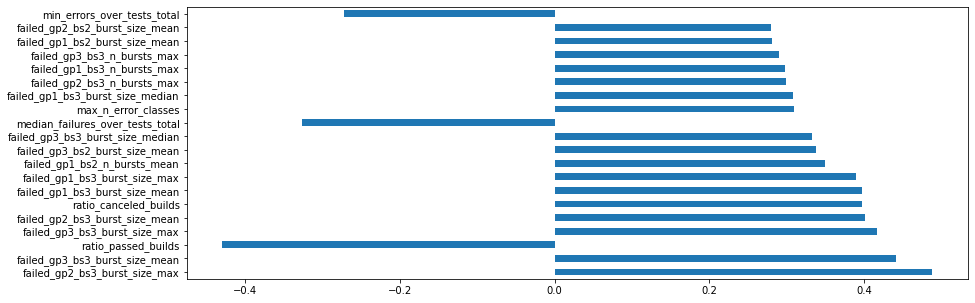

In [435]:
df = methods_pearson_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
df.head(20).plot(kind="barh")
#[[col for col in df.index if not "burst" in col]]

Text(0.5, 1.0, 'Top 20 spearman rank correlations with post release bugs (no burst metrics)')

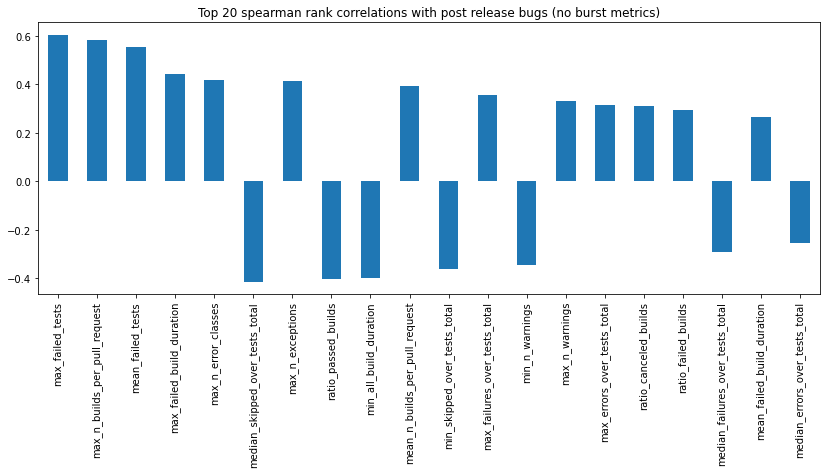

In [436]:
df = methods_spearman_corr_post_release_bugs[methods[1]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='failed_gp2_bs3_burst_size_max', ylabel='post_release_bugs'>

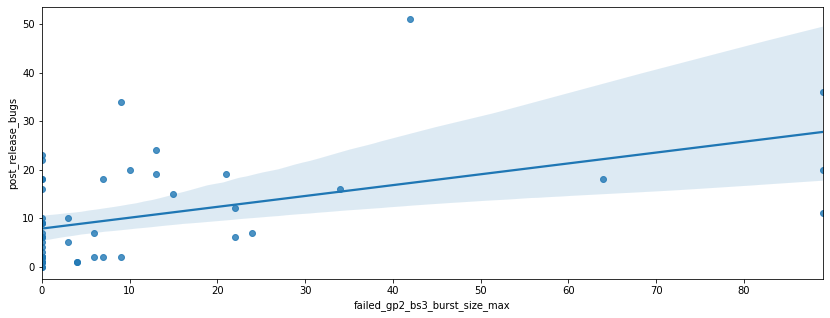

In [440]:
df_ind = methods_indep_var[methods[1]]
df_dep = methods_dep_var[methods[1]]
sns.regplot(df_ind.failed_gp2_bs3_burst_size_max, df_dep.post_release_bugs)